# Train Low Test Models

This notebook is a streamlined notebook for generating minima of low test accuracy through three different means:
- Dataset Poisoning
- Adding Noise to Data
- Decreasing Dataset Sizes

## Imports

In [1]:
# Standard library
import copy
import os
import sys
import time

# Third-party
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Local package imports
from minima_volume.dataset_funcs import (
    prepare_datasets,
    save_dataset,
    save_model,
)
from minima_volume.train_funcs import evaluate, train

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Input Parameters

In [2]:

# ==============================
# Base Input Parameters
# ==============================
# --- SEEDS ---
data_seed = 11            
model_seed = 1           

# --- Training configuration ---
epochs = 2000            

# --- Dataset configuration ---
base_data_size = 400      
dataset_type = "poison"    
dataset_quantities = [0, 10, 20, 50, 100]

# --- Output configuration ---
base_output_dir = ""     
save_generated_dataset = True   
save_generated_models = True    


## Model + Dataset Specific Code

This is for specific code.

In [3]:
# User specifies the model module name
from minima_volume.models import swiss_model_data as model_module

test_dataset_size = 2000

# Generate dataset
x_base, y_base, x_test, y_test = model_module.get_dataset(
    base_data_size=base_data_size,
    dataset_quantities=dataset_quantities,
    test_dataset_size=test_dataset_size,
    noise=0.3, # default swiss params
    extra_pts=1000,
    dataset_type=dataset_type,
    seed=data_seed
)

# Swiss specific initialization parameters
input_dim = 2
output_dim = 1
hidden_dims = [32]*5

# Grab model
model_template = model_module.get_model(input_dim=input_dim, hidden_dims=hidden_dims, output_dim=output_dim, device=device, seed=model_seed)

# Grab loss and metrics
loss_fn = model_module.get_loss_fn()
other_metrics = model_module.get_additional_metrics()

In [4]:
# Show the names of all parameters first (helps you locate layers)
print("=== Model Parameters ===")
for name, param in model_template.named_parameters():
    print(name, param.shape)

# Example: print first few weights from the first layer
first_layer_weights = next(model_template.parameters()).data
print("\n=== First layer weights (sample) ===")
print(first_layer_weights[:5, :5])  # first 5 rows, first 5 cols

# Example: print biases if available
for name, param in model_template.named_parameters():
    if "bias" in name:
        print(f"\n{name} (first 5 values):")
        print(param.data[:5])
        break

=== Model Parameters ===
model.0.weight torch.Size([32, 2])
model.0.bias torch.Size([32])
model.2.weight torch.Size([32, 32])
model.2.bias torch.Size([32])
model.4.weight torch.Size([32, 32])
model.4.bias torch.Size([32])
model.6.weight torch.Size([32, 32])
model.6.bias torch.Size([32])
model.8.weight torch.Size([32, 32])
model.8.bias torch.Size([32])
model.10.weight torch.Size([1, 32])
model.10.bias torch.Size([1])

=== First layer weights (sample) ===
tensor([[ 0.3643, -0.3121],
        [-0.1371,  0.3319],
        [-0.6657,  0.4241],
        [-0.1455,  0.3597],
        [ 0.0983, -0.0866]], device='cuda:0')

model.0.bias (first 5 values):
tensor([-0.3964, -0.1164, -0.0137,  0.1033, -0.5366], device='cuda:0')


## Training

We generate the various datasets used to train our models here, before training them. We record the losses, and what each model was trained on.

In [5]:
# ==============================
# Prepare datasets
# ==============================
x_base_train, y_base_train, x_additional, y_additional = prepare_datasets(
    x_base=x_base,
    y_base=y_base,
    dataset_type=dataset_type,
    dataset_quantities=dataset_quantities,
    base_data_size=base_data_size,
    data_seed=data_seed,
    seed_1=None,
    seed_2=None,
)

x_base_train = x_base_train.to(device)
y_base_train = y_base_train.to(device)
x_additional = x_additional.to(device)
y_additional = y_additional.to(device)
x_test = x_test.to(device)
y_test = y_test.to(device)

# ==============================
# Training loop
# ==============================
all_models = []

for additional_data in dataset_quantities:
    # Assemble training dataset
    x_train = torch.cat([x_base_train, x_additional[:additional_data]], dim=0)
    y_train = torch.cat([y_base_train, y_additional[:additional_data]], dim=0)

    # Initialize model (defined in the model-specific file)
    torch.manual_seed(model_seed)
    model = copy.deepcopy(model_template)
    optimizer = optim.AdamW(model.parameters(), lr=1e-3)
    batch_size = len(x_train)

    # Train model
    train_losses, train_other_metrics, test_losses, test_other_metrics = train(
        model = model,
        x_train = x_train, y_train = y_train,
        x_test = x_test, y_test = y_test,
        loss_fn = loss_fn,
        metrics = other_metrics,
        optimizer = optimizer,
        epochs=epochs,
        batch_size=batch_size,
        verbose_every=100,
    )
    
    # Build dictionary dynamically for additional metrics
    train_metrics_dict = {}
    test_metrics_dict = {}
    if train_other_metrics is not None:
        # train_other_metrics is a list of dicts per epoch
        for metric_name in train_other_metrics[0].keys():  # keys from first epoch
            train_metrics_dict[f"train_{metric_name}"] = [m[metric_name] for m in train_other_metrics]
            test_metrics_dict[f"test_{metric_name}"] = [m[metric_name] for m in test_other_metrics]
    
    # Store results
    trained_model = {
        "model": model,
        "train_losses": train_losses,
        "test_losses": test_losses,
        "additional_data": additional_data,
        "dataset_type": dataset_type,
        **train_metrics_dict,  # dynamically include additional metrics
        **test_metrics_dict,
    }
    
    all_models.append(trained_model)

    print(f"Completed training with {additional_data} additional samples of {dataset_type}")

    # Free memory (important for large GPU datasets)
    del x_train, y_train
    torch.cuda.empty_cache()


Epoch 1/2000: Train Loss 0.6916 | Test Loss 0.6912 | accs Train 0.5000 Test 0.4855


Epoch 100/2000: Train Loss 0.5639 | Test Loss 0.5592 | accs Train 0.6100 Test 0.6258


Epoch 200/2000: Train Loss 0.0317 | Test Loss 0.0319 | accs Train 0.9975 Test 0.9955


Epoch 300/2000: Train Loss 0.0019 | Test Loss 0.0082 | accs Train 1.0000 Test 0.9978


Epoch 400/2000: Train Loss 0.0006 | Test Loss 0.0072 | accs Train 1.0000 Test 0.9978


Epoch 500/2000: Train Loss 0.0003 | Test Loss 0.0069 | accs Train 1.0000 Test 0.9978


Epoch 600/2000: Train Loss 0.0002 | Test Loss 0.0069 | accs Train 1.0000 Test 0.9978


Epoch 700/2000: Train Loss 0.0002 | Test Loss 0.0068 | accs Train 1.0000 Test 0.9980


Epoch 800/2000: Train Loss 0.0001 | Test Loss 0.0068 | accs Train 1.0000 Test 0.9980


Epoch 900/2000: Train Loss 0.0001 | Test Loss 0.0068 | accs Train 1.0000 Test 0.9982


Epoch 1000/2000: Train Loss 0.0001 | Test Loss 0.0068 | accs Train 1.0000 Test 0.9982


Epoch 1100/2000: Train Loss 0.0001 | Test Loss 0.0068 | accs Train 1.0000 Test 0.9982


Epoch 1200/2000: Train Loss 0.0001 | Test Loss 0.0068 | accs Train 1.0000 Test 0.9985


Epoch 1300/2000: Train Loss 0.0000 | Test Loss 0.0068 | accs Train 1.0000 Test 0.9985


Epoch 1400/2000: Train Loss 0.0000 | Test Loss 0.0068 | accs Train 1.0000 Test 0.9985


Epoch 1500/2000: Train Loss 0.0000 | Test Loss 0.0069 | accs Train 1.0000 Test 0.9985


Epoch 1600/2000: Train Loss 0.0000 | Test Loss 0.0069 | accs Train 1.0000 Test 0.9985


Epoch 1700/2000: Train Loss 0.0000 | Test Loss 0.0069 | accs Train 1.0000 Test 0.9985


Epoch 1800/2000: Train Loss 0.0000 | Test Loss 0.0069 | accs Train 1.0000 Test 0.9985


Epoch 1900/2000: Train Loss 0.0000 | Test Loss 0.0070 | accs Train 1.0000 Test 0.9985


Epoch 2000/2000: Train Loss 0.0000 | Test Loss 0.0070 | accs Train 1.0000 Test 0.9985
Completed training with 0 additional samples of poison
Epoch 1/2000: Train Loss 0.6916 | Test Loss 0.6912 | accs Train 0.5024 Test 0.4848


Epoch 100/2000: Train Loss 0.5850 | Test Loss 0.5786 | accs Train 0.5878 Test 0.6010


Epoch 200/2000: Train Loss 0.0872 | Test Loss 0.0549 | accs Train 0.9756 Test 0.9948


Epoch 300/2000: Train Loss 0.0507 | Test Loss 0.0411 | accs Train 0.9780 Test 0.9900


Epoch 400/2000: Train Loss 0.0434 | Test Loss 0.0399 | accs Train 0.9780 Test 0.9890


Epoch 500/2000: Train Loss 0.0398 | Test Loss 0.0420 | accs Train 0.9756 Test 0.9870


Epoch 600/2000: Train Loss 0.0376 | Test Loss 0.0467 | accs Train 0.9805 Test 0.9860


Epoch 700/2000: Train Loss 0.0326 | Test Loss 0.0415 | accs Train 0.9854 Test 0.9880


Epoch 800/2000: Train Loss 0.0316 | Test Loss 0.0415 | accs Train 0.9829 Test 0.9872


Epoch 900/2000: Train Loss 0.0280 | Test Loss 0.0463 | accs Train 0.9878 Test 0.9875


Epoch 1000/2000: Train Loss 0.0257 | Test Loss 0.0513 | accs Train 0.9902 Test 0.9870


Epoch 1100/2000: Train Loss 0.0228 | Test Loss 0.0553 | accs Train 0.9951 Test 0.9868


Epoch 1200/2000: Train Loss 0.0208 | Test Loss 0.0615 | accs Train 0.9927 Test 0.9858


Epoch 1300/2000: Train Loss 0.0205 | Test Loss 0.0778 | accs Train 0.9902 Test 0.9825


Epoch 1400/2000: Train Loss 0.0181 | Test Loss 0.0814 | accs Train 0.9927 Test 0.9835


Epoch 1500/2000: Train Loss 0.0175 | Test Loss 0.0966 | accs Train 0.9976 Test 0.9810


Epoch 1600/2000: Train Loss 0.0395 | Test Loss 0.0651 | accs Train 0.9805 Test 0.9848


Epoch 1700/2000: Train Loss 0.0306 | Test Loss 0.0584 | accs Train 0.9854 Test 0.9830


Epoch 1800/2000: Train Loss 0.0284 | Test Loss 0.0585 | accs Train 0.9878 Test 0.9832


Epoch 1900/2000: Train Loss 0.0269 | Test Loss 0.0583 | accs Train 0.9878 Test 0.9830


Epoch 2000/2000: Train Loss 0.0258 | Test Loss 0.0590 | accs Train 0.9927 Test 0.9828
Completed training with 10 additional samples of poison
Epoch 1/2000: Train Loss 0.6917 | Test Loss 0.6912 | accs Train 0.5024 Test 0.4843


Epoch 100/2000: Train Loss 0.6041 | Test Loss 0.5895 | accs Train 0.6095 Test 0.6208


Epoch 200/2000: Train Loss 0.1397 | Test Loss 0.0756 | accs Train 0.9524 Test 0.9948


Epoch 300/2000: Train Loss 0.0876 | Test Loss 0.0600 | accs Train 0.9643 Test 0.9902


Epoch 400/2000: Train Loss 0.0686 | Test Loss 0.0623 | accs Train 0.9738 Test 0.9778


Epoch 500/2000: Train Loss 0.0608 | Test Loss 0.0700 | accs Train 0.9690 Test 0.9735


Epoch 600/2000: Train Loss 0.0578 | Test Loss 0.0753 | accs Train 0.9714 Test 0.9700


Epoch 700/2000: Train Loss 0.0521 | Test Loss 0.0888 | accs Train 0.9667 Test 0.9660


Epoch 800/2000: Train Loss 0.0486 | Test Loss 0.0868 | accs Train 0.9786 Test 0.9688


Epoch 900/2000: Train Loss 0.0476 | Test Loss 0.1013 | accs Train 0.9714 Test 0.9607


Epoch 1000/2000: Train Loss 0.0452 | Test Loss 0.0918 | accs Train 0.9762 Test 0.9695


Epoch 1100/2000: Train Loss 0.0440 | Test Loss 0.1229 | accs Train 0.9881 Test 0.9595


Epoch 1200/2000: Train Loss 0.0388 | Test Loss 0.1040 | accs Train 0.9833 Test 0.9653


Epoch 1300/2000: Train Loss 0.0363 | Test Loss 0.1042 | accs Train 0.9881 Test 0.9663


Epoch 1400/2000: Train Loss 0.0391 | Test Loss 0.1110 | accs Train 0.9810 Test 0.9650


Epoch 1500/2000: Train Loss 0.0415 | Test Loss 0.1073 | accs Train 0.9833 Test 0.9695


Epoch 1600/2000: Train Loss 0.0319 | Test Loss 0.1191 | accs Train 0.9905 Test 0.9653


Epoch 1700/2000: Train Loss 0.0302 | Test Loss 0.1216 | accs Train 0.9929 Test 0.9650


Epoch 1800/2000: Train Loss 0.0294 | Test Loss 0.1348 | accs Train 0.9929 Test 0.9633


Epoch 1900/2000: Train Loss 0.0435 | Test Loss 0.1125 | accs Train 0.9786 Test 0.9692


Epoch 2000/2000: Train Loss 0.0285 | Test Loss 0.1317 | accs Train 0.9929 Test 0.9640
Completed training with 20 additional samples of poison
Epoch 1/2000: Train Loss 0.6918 | Test Loss 0.6912 | accs Train 0.5000 Test 0.4843


Epoch 100/2000: Train Loss 0.6146 | Test Loss 0.5824 | accs Train 0.6178 Test 0.6558


Epoch 200/2000: Train Loss 0.2803 | Test Loss 0.1688 | accs Train 0.8889 Test 0.9715


Epoch 300/2000: Train Loss 0.2274 | Test Loss 0.1345 | accs Train 0.9044 Test 0.9725


Epoch 400/2000: Train Loss 0.2096 | Test Loss 0.1250 | accs Train 0.9156 Test 0.9690


Epoch 500/2000: Train Loss 0.1928 | Test Loss 0.1371 | accs Train 0.9067 Test 0.9603


Epoch 600/2000: Train Loss 0.1774 | Test Loss 0.1328 | accs Train 0.9244 Test 0.9620


Epoch 700/2000: Train Loss 0.1631 | Test Loss 0.1374 | accs Train 0.9311 Test 0.9603


Epoch 800/2000: Train Loss 0.1453 | Test Loss 0.1573 | accs Train 0.9356 Test 0.9417


Epoch 900/2000: Train Loss 0.1271 | Test Loss 0.1514 | accs Train 0.9489 Test 0.9407


Epoch 1000/2000: Train Loss 0.1174 | Test Loss 0.1494 | accs Train 0.9556 Test 0.9433


Epoch 1100/2000: Train Loss 0.1103 | Test Loss 0.1877 | accs Train 0.9600 Test 0.9243


Epoch 1200/2000: Train Loss 0.0992 | Test Loss 0.1719 | accs Train 0.9644 Test 0.9367


Epoch 1300/2000: Train Loss 0.0969 | Test Loss 0.2006 | accs Train 0.9622 Test 0.9260


Epoch 1400/2000: Train Loss 0.0911 | Test Loss 0.2159 | accs Train 0.9622 Test 0.9203


Epoch 1500/2000: Train Loss 0.0882 | Test Loss 0.2228 | accs Train 0.9644 Test 0.9267


Epoch 1600/2000: Train Loss 0.0842 | Test Loss 0.2495 | accs Train 0.9667 Test 0.9133


Epoch 1700/2000: Train Loss 0.0776 | Test Loss 0.2317 | accs Train 0.9733 Test 0.9237


Epoch 1800/2000: Train Loss 0.0753 | Test Loss 0.2426 | accs Train 0.9711 Test 0.9240


Epoch 1900/2000: Train Loss 0.0755 | Test Loss 0.2775 | accs Train 0.9689 Test 0.9120


Epoch 2000/2000: Train Loss 0.0733 | Test Loss 0.2658 | accs Train 0.9711 Test 0.9177
Completed training with 50 additional samples of poison
Epoch 1/2000: Train Loss 0.6922 | Test Loss 0.6913 | accs Train 0.4980 Test 0.5098


Epoch 100/2000: Train Loss 0.6355 | Test Loss 0.5918 | accs Train 0.6080 Test 0.6910


Epoch 200/2000: Train Loss 0.4504 | Test Loss 0.3047 | accs Train 0.7960 Test 0.9445


Epoch 300/2000: Train Loss 0.3890 | Test Loss 0.2675 | accs Train 0.8240 Test 0.9265


Epoch 400/2000: Train Loss 0.3554 | Test Loss 0.2542 | accs Train 0.8420 Test 0.9270


Epoch 500/2000: Train Loss 0.3371 | Test Loss 0.2788 | accs Train 0.8460 Test 0.9008


Epoch 600/2000: Train Loss 0.3149 | Test Loss 0.2760 | accs Train 0.8540 Test 0.9035


Epoch 700/2000: Train Loss 0.2971 | Test Loss 0.2732 | accs Train 0.8680 Test 0.9080


Epoch 800/2000: Train Loss 0.2895 | Test Loss 0.2668 | accs Train 0.8620 Test 0.9130


Epoch 900/2000: Train Loss 0.2755 | Test Loss 0.3058 | accs Train 0.8760 Test 0.8948


Epoch 1000/2000: Train Loss 0.2692 | Test Loss 0.3531 | accs Train 0.8820 Test 0.8802


Epoch 1100/2000: Train Loss 0.2573 | Test Loss 0.3601 | accs Train 0.8900 Test 0.8758


Epoch 1200/2000: Train Loss 0.2417 | Test Loss 0.3391 | accs Train 0.8960 Test 0.8932


Epoch 1300/2000: Train Loss 0.2342 | Test Loss 0.3746 | accs Train 0.8980 Test 0.8785


Epoch 1400/2000: Train Loss 0.2297 | Test Loss 0.3850 | accs Train 0.8960 Test 0.8828


Epoch 1500/2000: Train Loss 0.2200 | Test Loss 0.4019 | accs Train 0.9060 Test 0.8778


Epoch 1600/2000: Train Loss 0.2143 | Test Loss 0.4282 | accs Train 0.9100 Test 0.8678


Epoch 1700/2000: Train Loss 0.2116 | Test Loss 0.4232 | accs Train 0.9040 Test 0.8750


Epoch 1800/2000: Train Loss 0.2088 | Test Loss 0.4680 | accs Train 0.9040 Test 0.8622


Epoch 1900/2000: Train Loss 0.2087 | Test Loss 0.4523 | accs Train 0.9060 Test 0.8665


Epoch 2000/2000: Train Loss 0.2077 | Test Loss 0.4700 | accs Train 0.9020 Test 0.8648
Completed training with 100 additional samples of poison


## Training Summary

In [6]:
# ====================================
# Summary of Training Results
# ====================================
print("=== True Generalization ===")
for model_data in all_models:
    model = model_data["model"]
    additional_data = model_data["additional_data"]

    test_loss, test_metrics = evaluate(
        model=model,
        x_test=x_test,
        y_test=y_test,
        loss_fn=loss_fn,
        metrics=other_metrics
    )

    metrics_str = " | ".join([f"{name}: {val:.4f}" for name, val in test_metrics.items()])
    print(
        f"{additional_data:>4} samples | "
        f"Test Loss: {test_loss:.4f}" + (f" | {metrics_str}" if metrics_str else "")
    )

print("\n=== Model Diagnostics by Training Data ===")
for additional_data in dataset_quantities:
    # Build dataset with this many additional samples
    x_train = torch.cat([x_base_train, x_additional[:additional_data]], dim=0)
    y_train = torch.cat([y_base_train, y_additional[:additional_data]], dim=0)

    print(f"\nDataset type: {dataset_type}, additional samples: {additional_data}")

    for model_data in all_models:
        model = model_data["model"]
        model_additional_data = model_data["additional_data"]

        train_loss, train_metrics = evaluate(
            model=model,
            x_test=x_train,
            y_test=y_train,
            loss_fn=loss_fn,
            metrics=other_metrics
        )

        metrics_str = " | ".join([f"{name}: {val:.4f}" for name, val in train_metrics.items()])
        print(
            f" Model {model_additional_data:>4} | "
            f"Train Loss: {train_loss:.4f}" + (f" | {metrics_str}" if metrics_str else "")
        )

    # Free memory if large
    del x_train, y_train
    torch.cuda.empty_cache()

=== True Generalization ===
   0 samples | Test Loss: 0.0070 | accs: 0.9985
  10 samples | Test Loss: 0.0590 | accs: 0.9828
  20 samples | Test Loss: 0.1317 | accs: 0.9640
  50 samples | Test Loss: 0.2658 | accs: 0.9177
 100 samples | Test Loss: 0.4700 | accs: 0.8648

=== Model Diagnostics by Training Data ===

Dataset type: poison, additional samples: 0
 Model    0 | Train Loss: 0.0000 | accs: 1.0000
 Model   10 | Train Loss: 0.0122 | accs: 0.9975
 Model   20 | Train Loss: 0.0140 | accs: 0.9975
 Model   50 | Train Loss: 0.0370 | accs: 0.9925
 Model  100 | Train Loss: 0.0954 | accs: 0.9750

Dataset type: poison, additional samples: 10
 Model    0 | Train Loss: 0.3483 | accs: 0.9756
 Model   10 | Train Loss: 0.0257 | accs: 0.9927
 Model   20 | Train Loss: 0.0244 | accs: 0.9951
 Model   50 | Train Loss: 0.0433 | accs: 0.9927
 Model  100 | Train Loss: 0.1126 | accs: 0.9659

Dataset type: poison, additional samples: 20
 Model    0 | Train Loss: 0.6497 | accs: 0.9524
 Model   10 | Train Los

### Model + Data Specific Verification

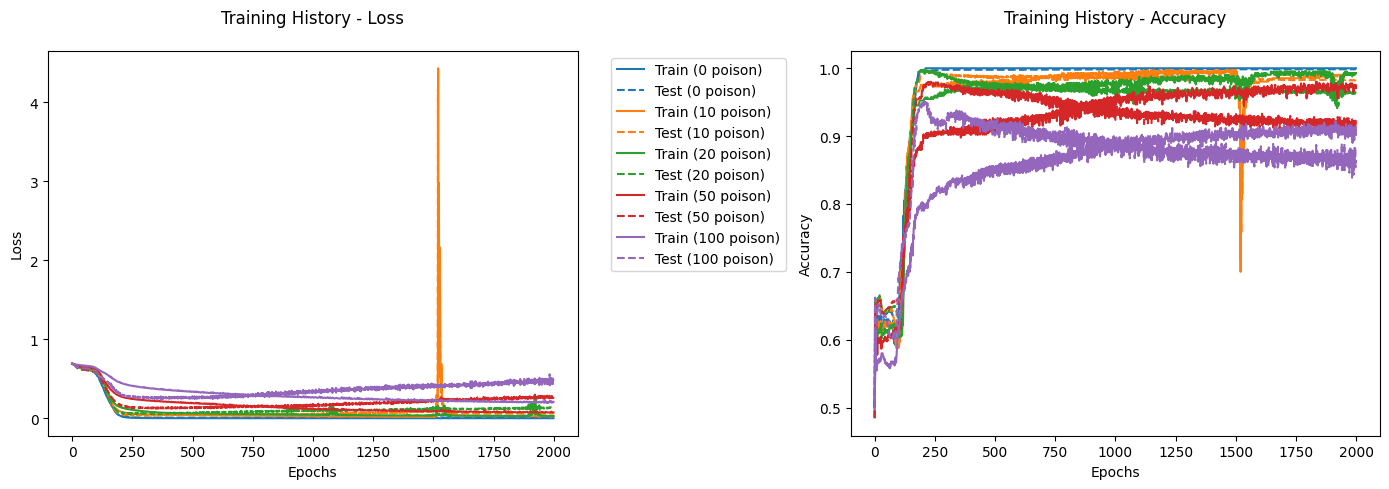

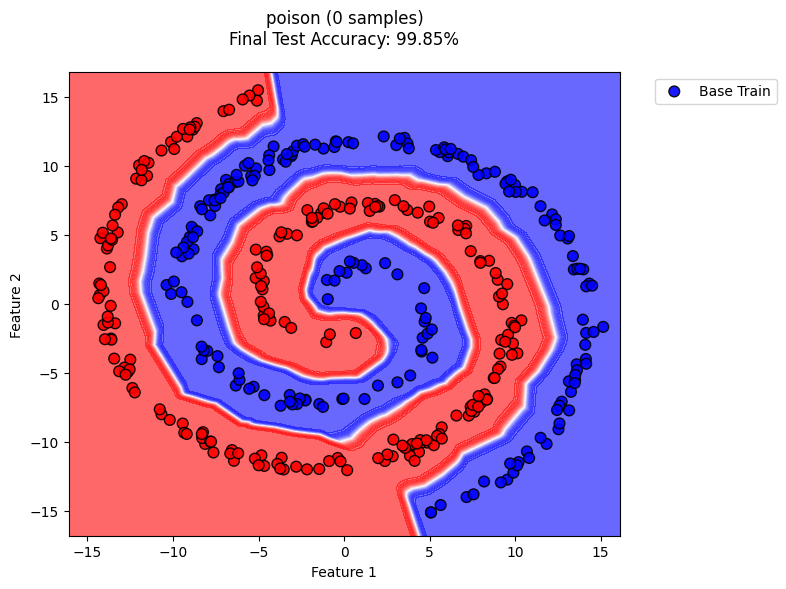

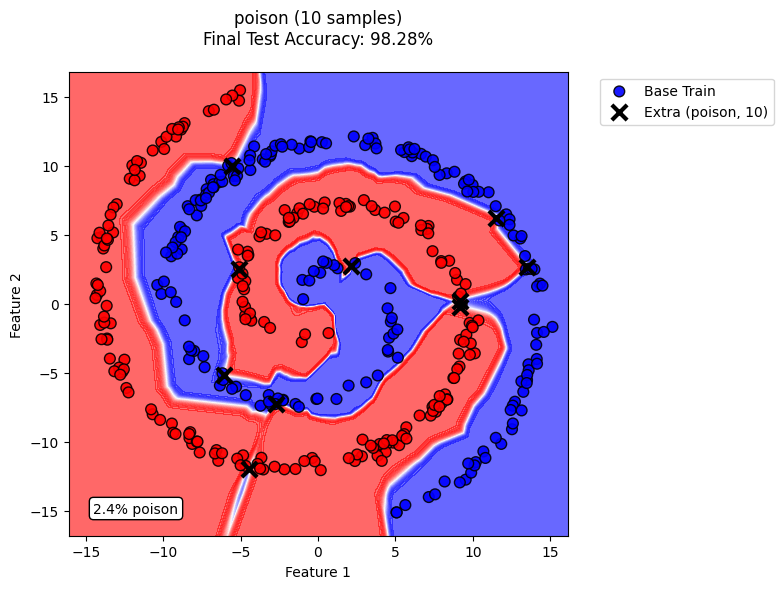

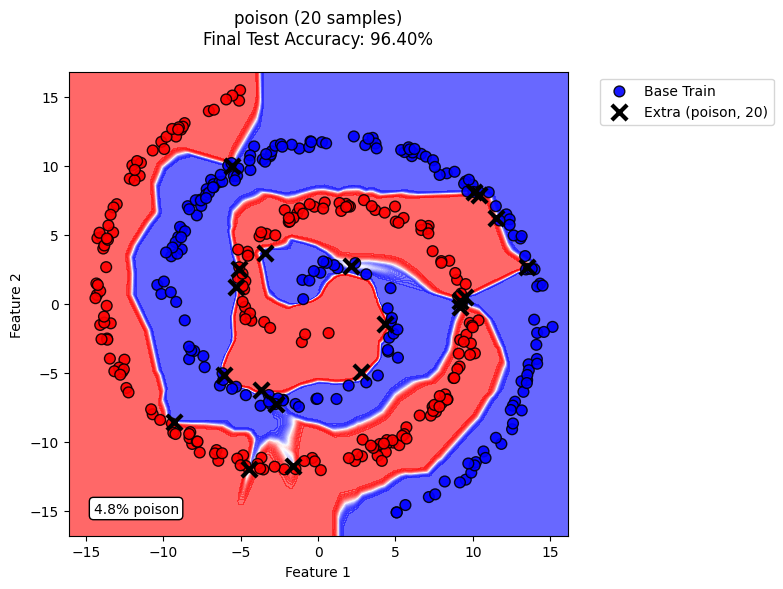

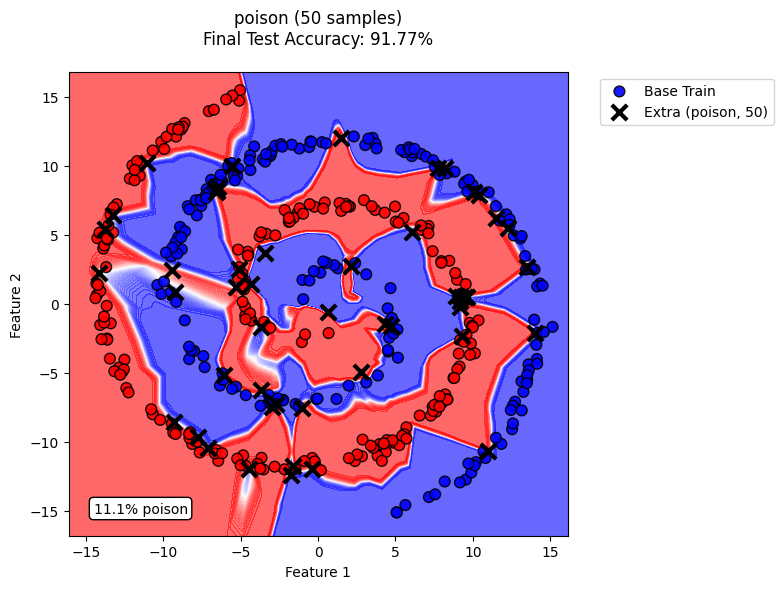

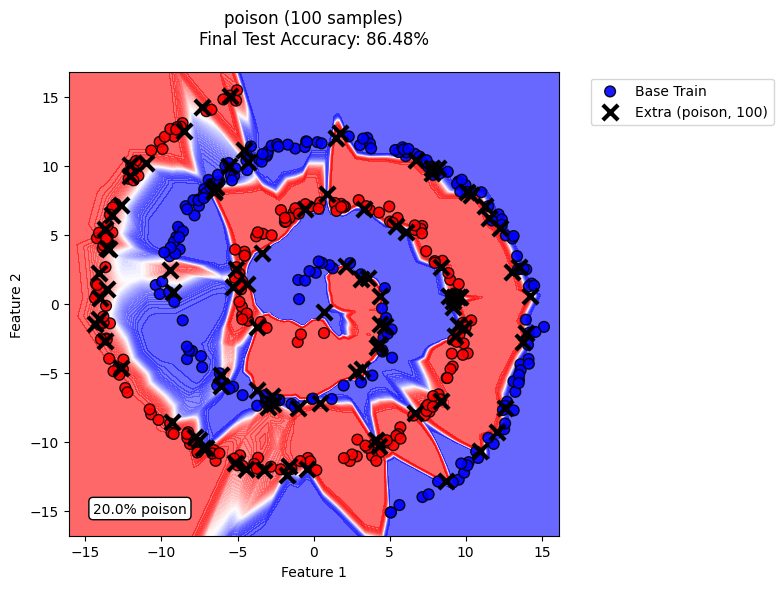

In [7]:
model_module.verify_model_results(
    all_models=all_models,
    x_base_train=x_base_train,
    y_base_train=y_base_train,
    x_additional=x_additional,
    y_additional=y_additional,
    x_test=x_test,
    y_test=y_test,
    dataset_quantities=dataset_quantities,
    dataset_type=dataset_type,
)

## Model Saving

In [8]:
# ====================================
# Save Datasets and Models
# ====================================
output_folder = "models_and_data"
# Save dataset (Possible to skip)
if save_generated_dataset:
    save_dataset(
        folder=output_folder,
        filename="dataset.pt",
        x_base_train=x_base_train,
        y_base_train=y_base_train,
        x_additional=x_additional,
        y_additional=y_additional,
        x_test=x_test,
        y_test=y_test,
        dataset_quantities=dataset_quantities,
        dataset_type=dataset_type,
    )
    print(f"Saved dataset to {output_folder}/dataset.pt")

# Save trained models
if save_generated_models:
    for model_data in all_models:
        filename = f"model_additional_{model_data['additional_data']}.pt"
        save_model(
            folder=output_folder,
            filename=filename,
            model=model_data["model"],
            train_losses=model_data["train_losses"],
            train_accs=model_data["train_accs"],
            test_losses=model_data["test_losses"],
            test_accs=model_data["test_accs"],
            additional_data=model_data["additional_data"],
            dataset_type=model_data["dataset_type"],
        )
        print(f"Saved model: {output_folder}/{filename}")

✅ Dataset saved to models_and_data\dataset.pt
Saved dataset to models_and_data/dataset.pt
✅ Model saved to models_and_data\model_additional_0.pt
Saved model: models_and_data/model_additional_0.pt
✅ Model saved to models_and_data\model_additional_10.pt
Saved model: models_and_data/model_additional_10.pt
✅ Model saved to models_and_data\model_additional_20.pt
Saved model: models_and_data/model_additional_20.pt
✅ Model saved to models_and_data\model_additional_50.pt
Saved model: models_and_data/model_additional_50.pt
✅ Model saved to models_and_data\model_additional_100.pt
Saved model: models_and_data/model_additional_100.pt
